In [1]:
from scripts.BZ2Reader import bz2reader
from glob import glob
import os, re, pickle
from pprint import pprint
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.feature_extraction.text import HashingVectorizer

%matplotlib inline

In [20]:
# Args
data_dir = "../data"
num_posts = 10000
hash_vect = "models/hash_vect.pk"

In [21]:
def data_processing(bz2files, max_lines=-1):
    for bz2file in  bz2files:
        bzr = bz2reader(fname=bz2file,
                        keys=['body'],
                        max_lines=max_lines)
        for data in bzr.select_keys():
            yield data['body']

In [22]:
data_path = os.path.join(data_dir, '*.bz2')         # arg var needs fixed
bzfile = glob(data_path)
d = data_processing(bzfile, num_posts)          # arg var needs fixed
print('loading data...', end=' ')
data = [l for l in d]
print('done')

loading data... done


In [23]:
# ### Data processing steps
# %%
# Remove punctuation
print('processing data...', end=' ')
data = [re.sub('[,\\.!?]', '', x) for x in data]
# Convert the titles to lowercase
data = [x.lower() for x in data]
# Remove post with less than 10 words
data = [x for x in data if len(x.split(' '))>10]
print('done')
# display some data
print('first 4 posts:')
pprint(data[:3])
print('\n')



processing data... done
first 4 posts:
['i was thinking 170k max but if we get another player off the books (gibson) '
 'there would be a small bit more room to maneuver',
 'a baton is more likely to kill someone than a taser',
 'cut him a break he probably just finished watching training day ']




In [24]:
print('loading hash vectorizer...', end=' ')
hash_vectorizer = pickle.load(open(hash_vect, 'rb'))
hash_data = hash_vectorizer.transform(data)
print('done')

loading hash vectorizer... done


In [30]:
# Split up the data
train_hashed = hash_data[:5000]
test_hashed = hash_data[5000:]
print("Shape of train set: {}".format(train_hashed.shape))
print("Shape of test set: {}".format(test_hashed.shape))

Shape of train set: (5000, 40000)
Shape of test set: (673, 40000)


In [32]:
# Scale the data
hashed_scaled = StandardScaler(with_mean=False).fit_transform(hash_data)
train_hashed_scaled = hashed_scaled[:5000]
test_hashed_scaled = hashed_scaled[5000:]

In [29]:
# # PCA Doesnt work with Sparse matrices
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(train_hashed)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [33]:
print("Performing dimensionality reduction using LSA")
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(train_hashed)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 0.093903s
Explained variance of the SVD step: 2%


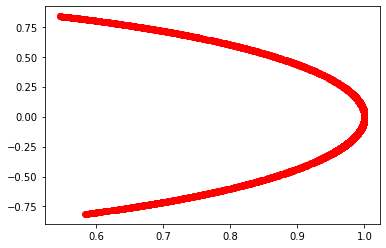

In [34]:
# # Ran with 5000 observations
# plt.plot(X.T[0], X.T[1], 'ro')
# plt.show()



In [50]:
Y = lsa.transform(test_hashed)
Y_xposed = Y.T

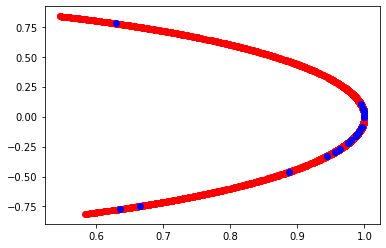

In [62]:
plt.plot(X.T[0], X.T[1], 'ro', Y_disp.T[0][:25], Y_disp.T[1][:25], 'bo')
plt.show()


In [75]:
# Try plotting in 3d

print("Performing dimensionality reduction using LSA")
t0 = time()
svd = TruncatedSVD(n_components=3)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_3 = lsa.fit_transform(train_hashed)
Y_3 = lsa.transform(test_hashed)
print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


Performing dimensionality reduction using LSA
done in 0.124254s
Explained variance of the SVD step: 2%


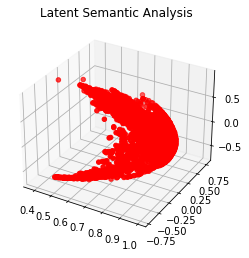

In [73]:
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# x = X_3.T[0]
# y = X_3.T[1]
# z = X_3.T[2]
#
# fig = plt.figure()
# ax = plt.axes(projection='3d')
#
# ax.scatter3D(x, y, z, color="red")
# plt.title("Latent Semantic Analysis")
#
# plt.show()


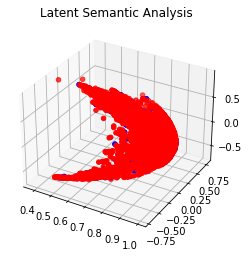

In [77]:
# Add test observations to the figure
x = X_3.T[0]
y = X_3.T[1]
z = X_3.T[2]
x2 = Y_3.T[0]
y2 = Y_3.T[1]
z2 = Y_3.T[2]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x2, y2, z2, color="blue")
ax.scatter3D(x, y, z, color="red")
ax.scatter3D(x2, y2, z2, color="blue")
plt.title("Latent Semantic Analysis")

plt.show()